In [23]:
import pandas as pd
import numpy as np

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [24]:
def candidates_in_neighbourhood(G, candidates, node):
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in sub_G.nodes() if x in candidates]
    if candidates_in_neighbourhood:
        return candidates_in_neighbourhood
    else:
        return []

In [25]:
def candidates_at_distance(dict_distances, node, d):
    return len([dist for dist in dict_distances.get(node).values() if dist == d])

In [26]:
interactome_df = pd.read_csv('./data/Interactome_human.tsv', sep='\t', header=None)
candidates = pd.read_pickle("./data/candidateGenesList_MMAF.p")

G = nx.from_pandas_edgelist(interactome_df, 0, 1, edge_attr=True)

candidates_MMAF = list(set([c for c in candidates if c in G.nodes()]))
nonCandidates_MMAF = [n for n in G.nodes() if n not in candidates_MMAF] 


print(f"Interactome size: {len(G.nodes())}, number of MMAF candidates in interactome: {len(candidates_MMAF)}")

Interactome size: 14465, number of MMAF candidates in interactome: 40


In [27]:
# find distances between MMAF and non-MMAF genes
dict_distances = {}
longest_distance = 0

for source_node in tqdm(nonCandidates_MMAF):
    dict_tmp = {}

    for target_node in candidates_MMAF:
        try:
            distance = nx.shortest_path_length(G, source_node, target_node)
            dict_tmp[target_node] = distance

            if distance > longest_distance:
                longest_distance = distance
        except:
            continue

    dict_distances[source_node] = dict_tmp

print(f"Longest distance between MMAF and non-MMAF gene: {longest_distance}")

  0%|          | 0/14425 [00:00<?, ?it/s]

100%|██████████| 14425/14425 [00:27<00:00, 530.35it/s]

Longest distance between MMAF and non-MMAF gene: 10


### Calculate new centrality for every non-MMAF gene

In [28]:
# set alpha parameter
alpha = 0.5

In [104]:
# calculate new centrality for every non-MMAF gene
dict_scores = {}

for i in tqdm(range(len(nonCandidates_MMAF))):
    node = nonCandidates_MMAF[i]
    score = 0

    to_A = [node] + list(set(candidates_MMAF))
    A = nx.adjacency_matrix(G, to_A).todense()

    for j in range(len(candidates_MMAF)):
        candidate = candidates_MMAF[j]
        
        try:
            d = nx.shortest_path_length(G, node, candidate)
            score += alpha ** d * np.linalg.matrix_power(A, d)[0][j+1]

        except:
            continue

        
    
    dict_scores[node] = round(score, 7)
    
dict_scores_sorted = dict(sorted(dict_scores.items(), key=lambda v: v[1], reverse=True))

100%|██████████| 14425/14425 [01:37<00:00, 148.41it/s]


In [105]:
# get more info about each node (degree, candidates at distances)
for n, score in dict_scores_sorted.items():
    dict_scores_sorted[n] = [round(score, 7), 
                             G.degree(n), 
                             candidates_at_distance(dict_distances, n, 1), 
                             candidates_at_distance(dict_distances, n, 2),
                             candidates_at_distance(dict_distances, n, 3),
                             candidates_at_distance(dict_distances, n, 4)]

df = pd.DataFrame.from_dict(dict_scores_sorted, 
                            orient='index', 
                            columns=['score', 'degree', 'candidates at d=1', 'candidates at d=2', 'candidates at d=3', 'candidates at d=4'])

In [106]:
# get gene names to ENSG
genes_df = pd.read_csv("./data/canonicalGenes.tsv", sep='\t')

df_res = df.merge(genes_df, left_index=True, right_on='ENSG')
df_res.sort_values(by='score', inplace=True, ascending=False)
df_res.reset_index(inplace=True, drop=True)

In [107]:
# get top 20 genes
df_top = df_res.head(20)
df_top

,score,degree,candidates at d=1,candidates at d=2,candidates at d=3,candidates at d=4,GENE,ENSG
0,1.750,81,3,4,19,12,TXLNA,ENSG00000084652
1,1.500,30,3,2,13,17,KIAA1328,ENSG00000150477
2,1.500,52,2,4,14,19,BORCS6,ENSG00000196544
3,1.250,62,2,5,20,12,KRT18,ENSG00000111057
4,1.250,47,2,4,16,17,TSC22D4,ENSG00000166925
5,1.250,103,2,6,15,16,NINL,ENSG00000101004
6,1.250,44,2,4,12,21,CEP44,ENSG00000164118
7,1.250,74,2,2,17,18,MED4,ENSG00000136146
8,1.250,32,2,1,12,23,CPSF7,ENSG00000149532
9,1.250,84,2,4,19,13,VPS52,ENSG00000223501


### Search for a specific gene

In [77]:
gene_of_interest = "TYMP"

score = df_res[df_res['GENE'] == gene_of_interest]['score'].values[0]

print(f"{gene_of_interest} score: {score}")

TYMP score: 0.53125


### Analyze the results

<Axes: xlabel='score', ylabel='Count'>

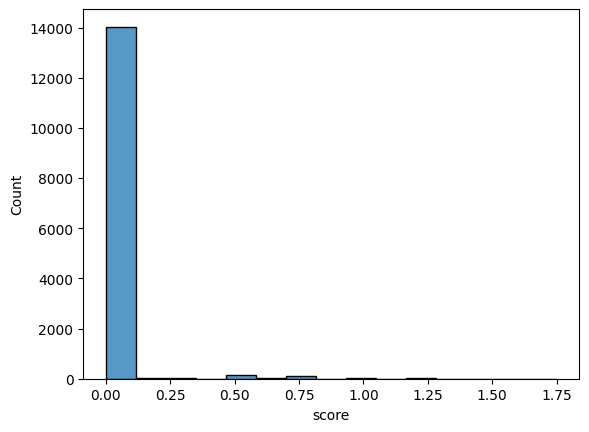

In [78]:
sns.histplot(data=df, x='score')

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='score'>

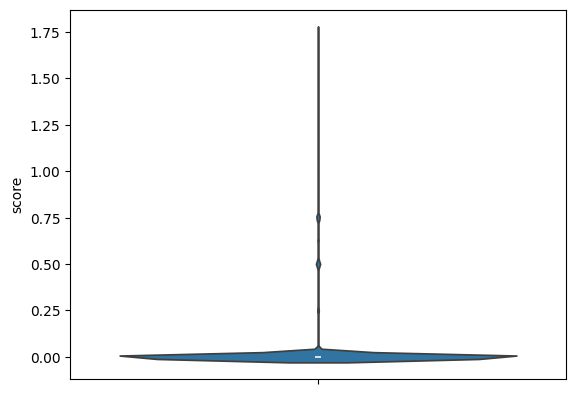

In [79]:
sns.violinplot(data=df, y='score')

### Analyze scores for new candidates from 13/02/2024

In [80]:
new_candidates = ['CLHC1', 'PHF20', 'NUSAP1', 'CDC20B', 'FAM221A', 'GALR3', 'LRRC9', 'KIF27', 'ZNF208', 'C6orf118', 'CCDC66', 'CCNA1', 'DDX43', 'FSCB', 'FHAD1', 'LRGUK', 'MYCBPAP', 'MYH7B', 'PCDHB15', 'SAMD15', 'SPACA9', 'SPATA24', 'SPATA6', 'TSSK4', 'TTLL2']
dict_new_candidates = dict([(gene, genes_df[genes_df['GENE'] == gene]['ENSG'].values[0]) for gene in new_candidates])

In [81]:
# check what percentage of new candidates is in interactome
len([nc for nc in dict_new_candidates.values() if nc in G.nodes()]) / len(dict_new_candidates.values())

0.68

In [91]:
# check scores of new candidates
df_new_candidates = df_res[df_res['ENSG'].isin(dict_new_candidates.values())]
df_new_candidates

,score,degree,candidates at d=1,candidates at d=2,candidates at d=3,candidates at d=4,GENE,ENSG
14667,0.625,1,1,1,4,11,CCDC66,ENSG00000180376
7244,0.000,3,0,1,4,13,MYCBPAP,ENSG00000136449
6677,0.000,17,0,3,10,24,CCNA1,ENSG00000133101
11610,0.000,3,0,0,6,26,SPACA9,ENSG00000165698
1440,0.000,5,0,0,6,17,MYH7B,ENSG00000078814
12763,0.000,7,0,1,3,27,SPATA24,ENSG00000170469
7856,0.000,1,0,0,1,21,TSSK4,ENSG00000139908
11255,0.000,11,0,3,7,23,CDC20B,ENSG00000164287
10834,0.000,1,0,0,3,10,CLHC1,ENSG00000162994
1482,0.000,1,0,0,0,0,DDX43,ENSG00000080007


In [83]:
[n for n in G.neighbors('ENSG00000180376')]

['ENSG00000174799']

In [84]:
[n for n in G.neighbors('ENSG00000096872')]

['ENSG00000122970',
 'ENSG00000196544',
 'ENSG00000174799',
 'ENSG00000101004',
 'ENSG00000073584',
 'ENSG00000196553',
 'ENSG00000205726',
 'ENSG00000150477']

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


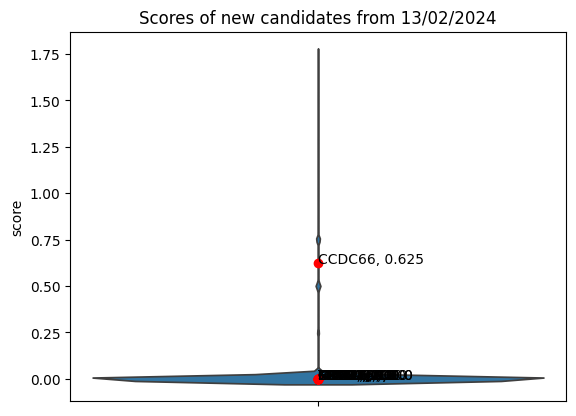

In [85]:
# plot scores of new candidates
sns.violinplot(data=df, y='score')
plt.title("Scores of new candidates from 13/02/2024")

for idx, row in df_new_candidates.iterrows():
    gene = row['GENE']
    score = row['score']
    plt.plot(score, 'or')
    plt.text(0, score, s=f"{gene}, {score}")

### Examine the highest-scoring gene ENSG00000180376

In [86]:
# get ENSG00000180376 neighbours
[n for n in G.neighbors('ENSG00000180376')]

['ENSG00000174799']

### Leave-one-out experiments

In [ ]:
for candidate in candidates_MMAF:
    # remove the candidate from candidate list
    left_out_idx = candidates_MMAF.index(candidate)

    candidates_MMAF_new = candidates_MMAF[:left_out_idx] + candidates_MMAF[left_out_idx+1:]

    print(f"Removed gene {candidate} from candidates")

    # set beta parameter for each node
    beta_dict = dict([(n, beta*int(n in candidates_MMAF_new)) for n in G])

    # calculate Katz centrality for each node
    res_KC_candidateInList = katz_centrality(G, alpha=alpha, beta=beta_dict)
    res_KC_candidateInList_sorted = dict(sorted(res_KC_candidateInList.items(), key=lambda v: v[1], reverse=True))

    # compare KC of each node before and after removal of candidate
    for idx, row in df.iterrows():
        KC_candidateInList = row['KC']
        KC_candidateNotInList = res_KC_candidateInList_sorted.get(idx)
        KC_diff = KC_candidateInList - KC_candidateNotInList

        dict_compare[idx] = {"KC_candidateInList": KC_candidateInList, "KC_candidateNotInList": KC_candidateNotInList, "KC_diff": KC_diff}

    df_compare = pd.DataFrame.from_dict(dict_compare, orient='index', columns=['KC_candidateInList', 'KC_candidateNotInList', 'KC_diff'])
    df_compare = df_compare.sort_values(by='KC_diff', ascending=False)

    # get top 10 most affected genes
    df_most_affected = df_compare.iloc[1:11]

    dict_most_affected[candidate] = df_most_affected.to_dict('index')